In [2]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import opendatasets as od
import pandas as pd
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

# Downloading the Data

In [5]:
od.download('https://www.kaggle.com/c/rossmann-store-sales')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tulasipatro
Your Kaggle Key: ··········


100%|██████████| 6.99M/6.99M [00:00<00:00, 88.1MB/s]


Extracting archive ./rossmann-store-sales/rossmann-store-sales.zip to ./rossmann-store-sales


In [6]:
os.listdir('rossmann-store-sales')

['store.csv', 'sample_submission.csv', 'train.csv', 'test.csv']

### Data Import

In [7]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('./rossmann-store-sales/store.csv')
test_df = pd.read_csv('./rossmann-store-sales/test.csv')
submission_df = pd.read_csv('./rossmann-store-sales/sample_submission.csv')

In [10]:
ross_df.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [11]:
test_df.head(5)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [12]:
store_df.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [13]:
submission_df.head(5)

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


### Merge the information from store_df into train_df and test_df.

In [16]:
train_df = ross_df.merge(store_df, how='left', on='Store')
test_df = test_df.merge(store_df, how='left', on='Store')

# Preprocessing and Feature Engineering

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

### Preprocessing the "Date" column

In [24]:
def split_date(df):
  df['Date'] = pd.to_datetime(df['Date'])
  df['Year'] = df.Date.dt.year
  df['Month'] = df.Date.dt.month
  df['Day'] = df.Date.dt.day
  df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [25]:
split_date(train_df)
split_date(test_df)

### Preprocessing the "Open" column

In [28]:
train_df[train_df.Open == 0].Sales.value_counts()


0    172817
Name: Sales, dtype: int64

In [30]:
# The sales are zero whenever the store is closed; it's better to remove the rows where the store is closed. 
# We won't remove any rows from the test set, since we need to make predictions for every row.



In [31]:
traib_df = train_df[train_df.Open == 1].copy()

### Competition
we can use the columns CompetitionOpenSince[Month/Year] columns from store_df to compute the number of months for which a competitor has been open near the store.

In [33]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [34]:
comp_months(train_df)
comp_months(test_df)

In [36]:
train_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(20)

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
13740,2015-07-19,4490.0,2014.0,5.0,14.0
579183,2014-01-28,980.0,2014.0,7.0,0.0
634494,2013-12-10,7860.0,2005.0,11.0,97.0
203775,2015-01-30,8860.0,2004.0,4.0,129.0
893895,2013-04-21,2460.0,2009.0,4.0,48.0
1013755,2013-01-04,3890.0,2006.0,11.0,74.0
547037,2014-02-26,2890.0,2003.0,10.0,124.0
121807,2015-04-13,8480.0,NaN,NaN,0.0
372358,2014-08-08,320.0,2005.0,12.0,104.0
495425,2014-04-13,540.0,2003.0,6.0,130.0


### Additional Promotion
We can also add some additional columns to indicate how long a store has been running Promo2 and whether a new round of Promo2 starts in the current month.

In [37]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [38]:
promo_cols(train_df)
promo_cols(test_df)

In [39]:
train_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
567900,2014-02-07,1,2014.0,40.0,"Jan,Apr,Jul,Oct",0.000000,0
675998,2013-11-03,1,2014.0,40.0,"Jan,Apr,Jul,Oct",0.000000,0
752589,2013-08-26,1,2011.0,14.0,"Jan,Apr,Jul,Oct",28.819672,0
562063,2014-02-13,0,NaN,NaN,NaN,0.000000,0
829222,2013-06-18,0,NaN,NaN,NaN,0.000000,0
968951,2013-02-13,1,2011.0,22.0,"Feb,May,Aug,Nov",20.557377,1
285821,2014-11-09,0,NaN,NaN,NaN,0.000000,0
758359,2013-08-21,0,NaN,NaN,NaN,0.000000,0
703738,2013-10-09,0,NaN,NaN,NaN,0.000000,0
622122,2013-12-21,0,NaN,NaN,NaN,0.000000,0


### Input and Target Variable

In [40]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [41]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [42]:
inputs = train_df[input_cols].copy()
targets = train_df[target_col].copy()

In [43]:
test_inputs = test_df[input_cols].copy()

#### Differentiating between Numerical and Categorical columns

In [44]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

### Check for missing values

In [45]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2642
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [46]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

## Missing values Treatment

Seems like competition distance is the only missing value, and we can simply fill it with the highest value (to indicate that competition is very far away).

In [47]:
max_distance = inputs.CompetitionDistance.max()

In [48]:
inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance, inplace=True)

## Scaling Numeric Values

In [51]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(inputs[numeric_cols])
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])


## Encode Categorical columns

In [52]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))

inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [53]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

# Training using Gradient Boosting

In [54]:
from xgboost import XGBRegressor
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

In [55]:
%%time
model.fit(X, targets)

[06:55:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 48 s, sys: 1.25 s, total: 49.2 s
Wall time: 28.5 s


XGBRegressor(max_depth=4, n_estimators=20, n_jobs=-1, random_state=42)

In [56]:
preds = model.predict(X)
preds

array([7011.282  , 6868.2446 , 6965.3926 , ...,  430.91428, 1969.8612 ,
        820.51227], dtype=float32)

In [57]:
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

rmse(preds, targets)
                              

2606.821785968511

In [58]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 30,30

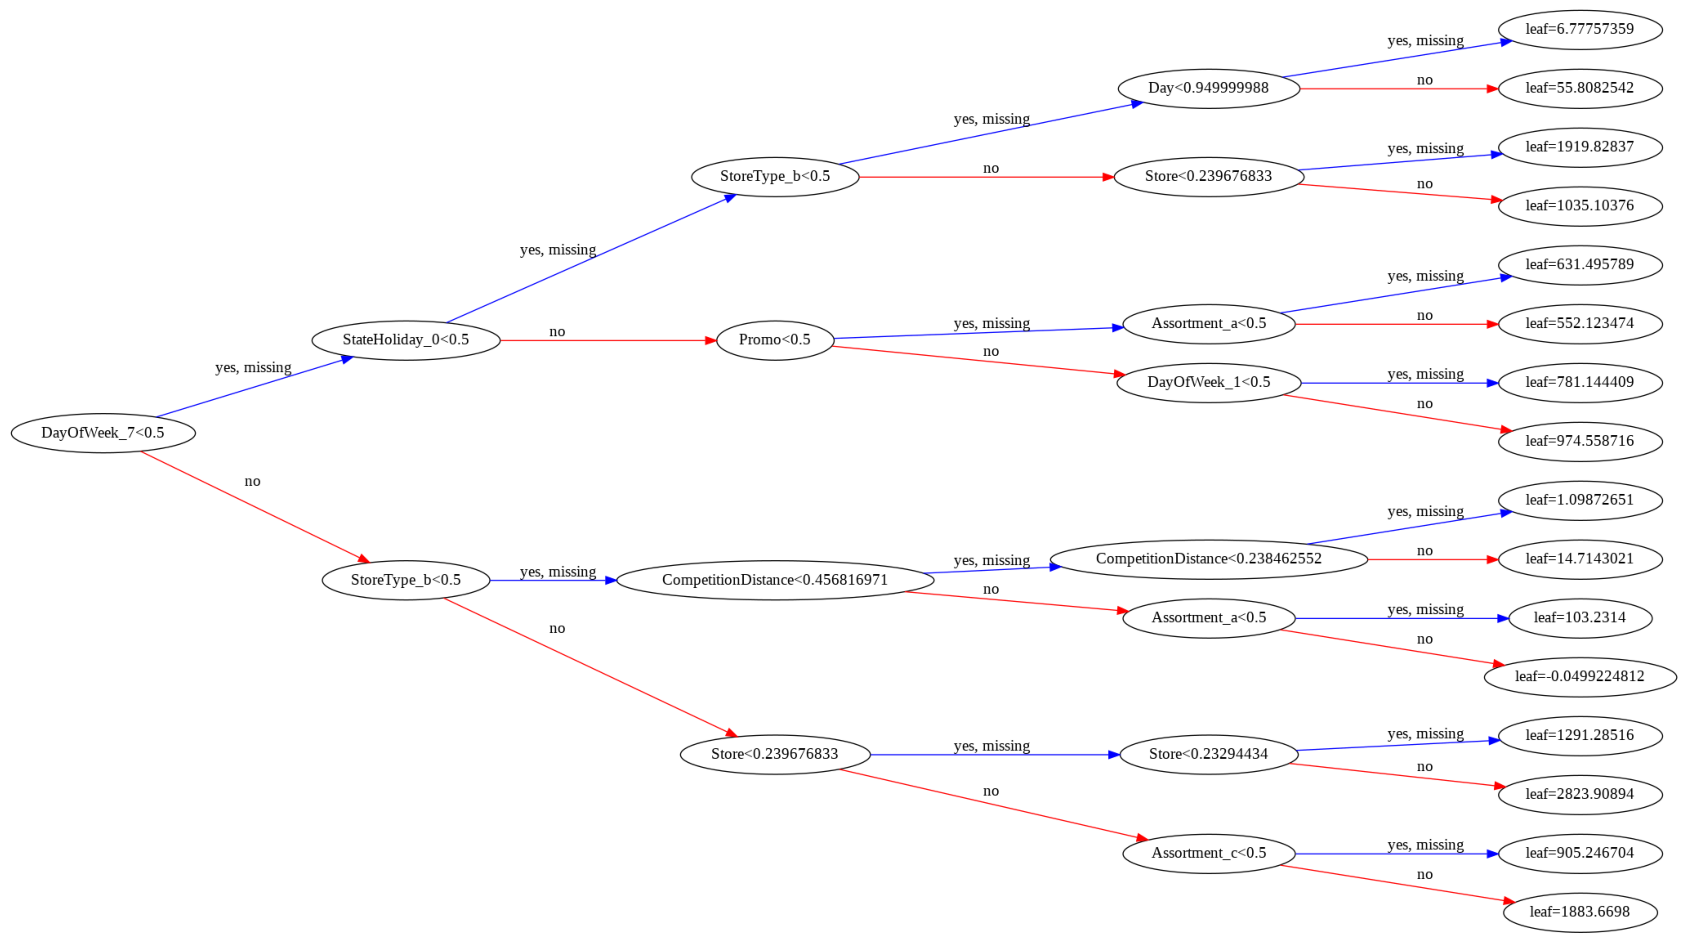

In [59]:
plot_tree(model, rankdir='LR');

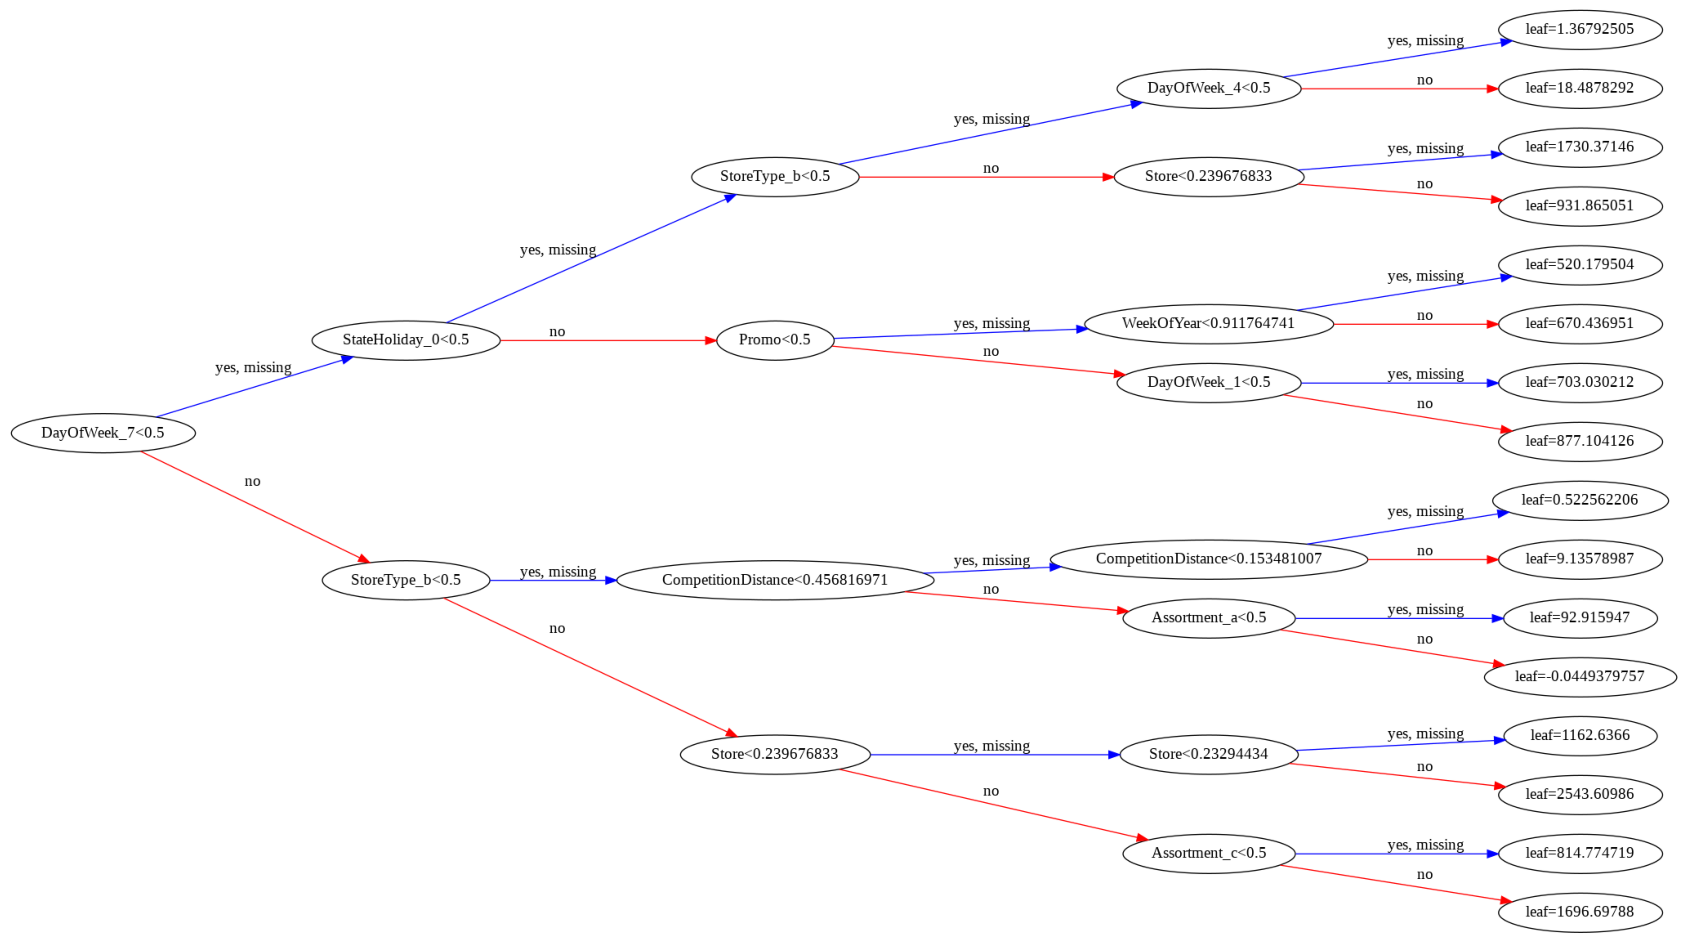

In [60]:
plot_tree(model, rankdir='LR', num_trees=1);

In [61]:
trees = model.get_booster().get_dump()

In [62]:
len(trees)

20

In [63]:
print(trees[0])

0:[DayOfWeek_7<0.5] yes=1,no=2,missing=1
	1:[StateHoliday_0<0.5] yes=3,no=4,missing=3
		3:[StoreType_b<0.5] yes=7,no=8,missing=7
			7:[Day<0.949999988] yes=15,no=16,missing=15
				15:leaf=6.77757359
				16:leaf=55.8082542
			8:[Store<0.239676833] yes=17,no=18,missing=17
				17:leaf=1919.82837
				18:leaf=1035.10376
		4:[Promo<0.5] yes=9,no=10,missing=9
			9:[Assortment_a<0.5] yes=19,no=20,missing=19
				19:leaf=631.495789
				20:leaf=552.123474
			10:[DayOfWeek_1<0.5] yes=21,no=22,missing=21
				21:leaf=781.144409
				22:leaf=974.558716
	2:[StoreType_b<0.5] yes=5,no=6,missing=5
		5:[CompetitionDistance<0.456816971] yes=11,no=12,missing=11
			11:[CompetitionDistance<0.238462552] yes=23,no=24,missing=23
				23:leaf=1.09872651
				24:leaf=14.7143021
			12:[Assortment_a<0.5] yes=25,no=26,missing=25
				25:leaf=103.2314
				26:leaf=-0.0499224812
		6:[Store<0.239676833] yes=13,no=14,missing=13
			13:[Store<0.23294434] yes=27,no=28,missing=27
				27:leaf=1291.28516
				28:leaf=2823.90894
			1

# Feature Importance

In [64]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [65]:
importance_df.head(10)

,feature,importance
18,DayOfWeek_7,0.561479
19,StateHoliday_0,0.153117
1,Promo,0.130611
12,DayOfWeek_1,0.044505
9,Month,0.022551
24,StoreType_b,0.020333
5,Promo2,0.015537
27,Assortment_a,0.013910
11,WeekOfYear,0.013147
8,Day,0.010712


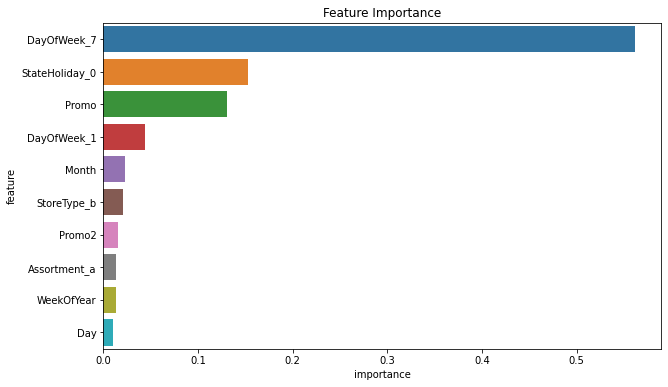

In [66]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

# K-Fold Cross Validation

In [67]:
from sklearn.model_selection import KFold

def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

In [68]:
kfold = KFold(n_splits=5)

In [69]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

[07:36:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 2605.145026665686, Validation RMSE: 2683.4904607865137
[07:36:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 2598.807395564221, Validation RMSE: 2668.348011641182
[07:37:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 2623.561017195304, Validation RMSE: 2557.8791514657987
[07:37:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 2590.5755333829243, Validation RMSE: 2698.202519557885
[07:38:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 2600.3053992739, Validation RMSE: 2512.980120171449


In [70]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

preds = predict_avg(models, X)
preds

array([6950.117  , 6762.366  , 6939.3296 , ...,  487.93018, 1499.9613 ,
        600.561  ], dtype=float32)

## Hyperparameter Tuning and Regularization

In [71]:
model

XGBRegressor(max_depth=4, n_estimators=20, n_jobs=-1, random_state=42)

In [72]:
?XGBRegressor

In [73]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)


In [76]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

n_estimators : 
The number of trees to be created. More trees = greater capacity of the model.

In [77]:
test_params(n_estimators=10)

[07:42:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 3452.8541492752674, Validation RMSE: 3465.3484184649765


In [78]:
test_params(n_estimators=100)

[07:43:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 2275.6672335985068, Validation RMSE: 2279.490616973673


In [79]:
test_params(n_estimators=300)

[07:45:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 2017.1052688972995, Validation RMSE: 2021.5552321860223


max_depth :  As you increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

In [80]:
test_params(max_depth=2)

[07:52:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 2396.163742361357, Validation RMSE: 2401.470699028774


In [81]:
test_params(max_depth=5)

[07:55:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 2015.8425259760484, Validation RMSE: 2017.4823844659966


In [82]:
test_params(max_depth=10)

[07:58:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: ignored

learning rate : The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

In [ ]:
test_params(n_estimators=50, learning_rate=0.01)

In [83]:
test_params(n_estimators=50, learning_rate=0.99)

[08:03:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 1885.338397586613, Validation RMSE: 1890.1199956704104


booster : Instead of using Decision Trees, XGBoost can also train a linear model for each iteration. This can be configured using booster.

In [84]:
test_params(booster='gblinear')

[08:06:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 3517.8391313897364, Validation RMSE: 3531.7876765066903


## Combining the parameters

In [85]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)

In [86]:
%%time
model.fit(X, targets)

[08:09:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1h 33min 13s, sys: 4.8 s, total: 1h 33min 18s
Wall time: 47min 40s


XGBRegressor(colsample_bytree=0.7, learning_rate=0.2, max_depth=10,
             n_estimators=1000, n_jobs=-1, random_state=42, subsample=0.9)

In [87]:
test_preds = model.predict(X_test)

In [88]:
submission_df['Sales']  = test_preds

In [89]:
test_df.Open.isna().sum()

11

In [90]:
submission_df['Sales'] = submission_df['Sales'] * test_df.Open.fillna(1.)
submission_df

,Id,Sales
0,1,4235.149414
1,2,7794.838867
2,3,9668.224609
3,4,7133.781250
4,5,7075.350098
...,...,...
41083,41084,1608.892090
41084,41085,5757.452148
41085,41086,5451.632324
41086,41087,21503.179688


In [91]:
submission_df.to_csv('submission.csv', index=None)

In [92]:
from IPython.display import FileLink
FileLink('submission.csv')

/content/submission.csv